## 2022/06/01 ~ 2022/09/15

- train 2022-06-01 00:00:00 ~ 2022-08-14 17:00:00
- test 2022-08-14 18:00:00 ~ 2022-09-15 23:00:00

## import

In [1]:
import pandas as pd
import numpy as np
import json
import urllib
import time

In [2]:
# 일반적인 모듈 
import numpy as np
import matplotlib.pyplot as plt 
import networkx as nx 
from tqdm import tqdm 

# 파이토치 관련 
import torch
import torch.nn.functional as F

# PyG 관련 
from torch_geometric.data import Data ## Data: 그래프자료형을 만드는 클래스

# STGCN 관련 
import torch_geometric_temporal
from torch_geometric_temporal.nn.recurrent import GConvGRU
from torch_geometric_temporal.signal import temporal_signal_split 

In [3]:
class RecurrentGCN(torch.nn.Module):
    def __init__(self, node_features, filters):
        super(RecurrentGCN, self).__init__()
        self.recurrent = GConvGRU(node_features, filters, 2)
        self.linear = torch.nn.Linear(filters, 1)

    def forward(self, x, edge_index, edge_weight):
        h = self.recurrent(x, edge_index, edge_weight)
        h = F.relu(h)
        h = self.linear(h)
        return h

In [4]:
from mysolar2 import SolarDatasetLoader

In [5]:
url = "https://raw.githubusercontent.com/pinkocto/noteda/main/posts/SOLAR/data2/stgcn_data2.json"
loader = SolarDatasetLoader(url)
dataset = loader.get_dataset(lags=4)

In [6]:
def minmaxscaler(arr):
    arr = arr - arr.min()
    arr = arr/arr.max()
    return arr 

In [7]:
dataset.edge_weight = minmaxscaler(dataset.edge_weight)
train_dataset, test_dataset = temporal_signal_split(dataset, train_ratio=0.7)

## Learn

In [8]:
model = RecurrentGCN(node_features=4, filters=32)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
model.train()

for epoch in tqdm(range(50)):
    for t, snapshot in enumerate(train_dataset):
        yt_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
        cost = torch.mean((yt_hat-snapshot.y)**2)
        cost.backward()
        optimizer.step()
        optimizer.zero_grad()

100%|██████████| 50/50 [05:26<00:00,  6.53s/it]


In [9]:
# import pickle 
# with open('./model3/normal_stgcn1_lag4_new.pickle','wb') as fw:
#     pickle.dump(model, fw)

In [10]:
# import pickle 
# with open('./model3/normal_stgcn1_lag4_new.pickle', 'rb') as f: 
#     model = pickle.load(f)

`-` train

- MSE: 0.2102 (before normalize)

In [26]:
model.eval()
cost = 0
for time, snapshot in enumerate(train_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.1966


`-` test

- MSE: 0.1899 (before normalize)

In [27]:
model.eval()
cost = 0
for time, snapshot in enumerate(test_dataset):
    y_hat = model(snapshot.x, snapshot.edge_index, snapshot.edge_attr)
    cost = cost + torch.mean((y_hat-snapshot.y)**2)
cost = cost / (time+1)
cost = cost.item()
print("MSE: {:.4f}".format(cost))

MSE: 0.1801


## Visualization

In [28]:
url = 'https://raw.githubusercontent.com/pinkocto/noteda/main/posts/SOLAR/data2/stgcn_data1.json'

In [29]:
data_dict = json.loads(urllib.request.urlopen(url).read())
V = list(data_dict['node_ids'].keys())
f = np.array(data_dict["FX"])

In [30]:
yhat_train = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in train_dataset]).detach().numpy()
yhat_test = torch.stack([model(snapshot.x,snapshot.edge_index, snapshot.edge_attr) for snapshot in test_dataset]).detach().numpy()

In [31]:
f.shape

(2568, 44)

In [32]:
yhat_test.shape[0] +  yhat_train.shape[0]

2564

In [33]:
yhat_test.shape, yhat_train.shape

((770, 44, 1), (1794, 44, 1))

In [34]:
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'NanumGothic'

### train

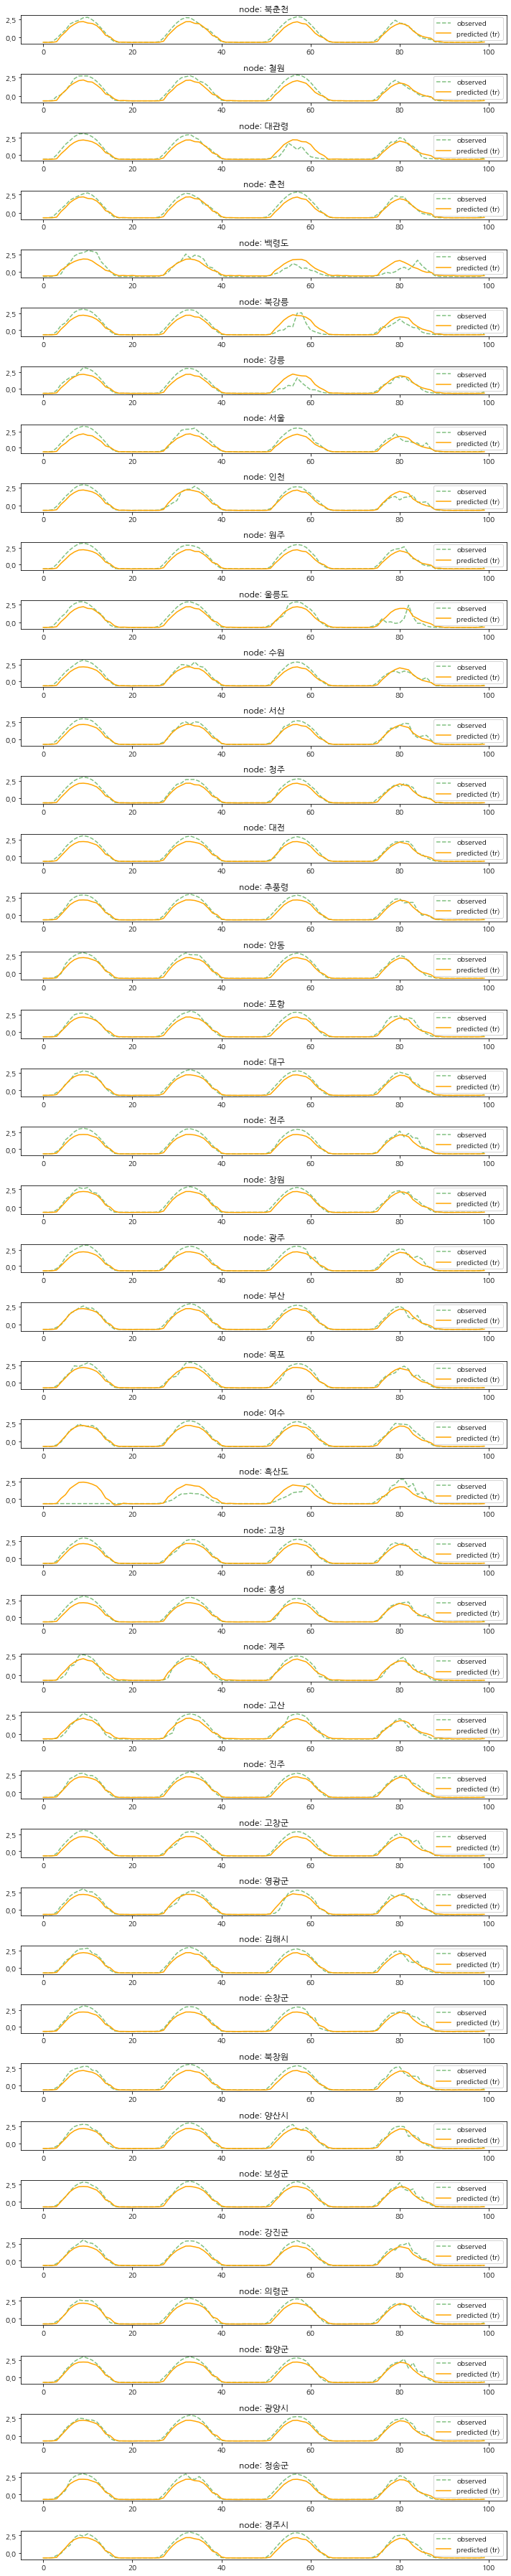

In [35]:
fig,ax = plt.subplots(44,1,figsize=(10,50))
lag= 0 
T = 100 
for k in range(44):
    ax[k].plot(np.array(train_dataset.targets)[lag:(lag+T),k],'--',alpha=0.5,label='observed', color='green')
    ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_train[:T,k],label='predicted (tr)', color = 'orange')
#    ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
fig.tight_layout()

# plt.savefig('stgcn-ver2-lag4-vis.png')

In [36]:
np.array(dataset.features).shape

(2564, 44, 4)

In [37]:
np.array(dataset.targets).shape

(2564, 44)

In [38]:
np.array(train_dataset.targets).shape

(1794, 44)

In [39]:
np.array(test_dataset.targets).shape

(770, 44)

### test

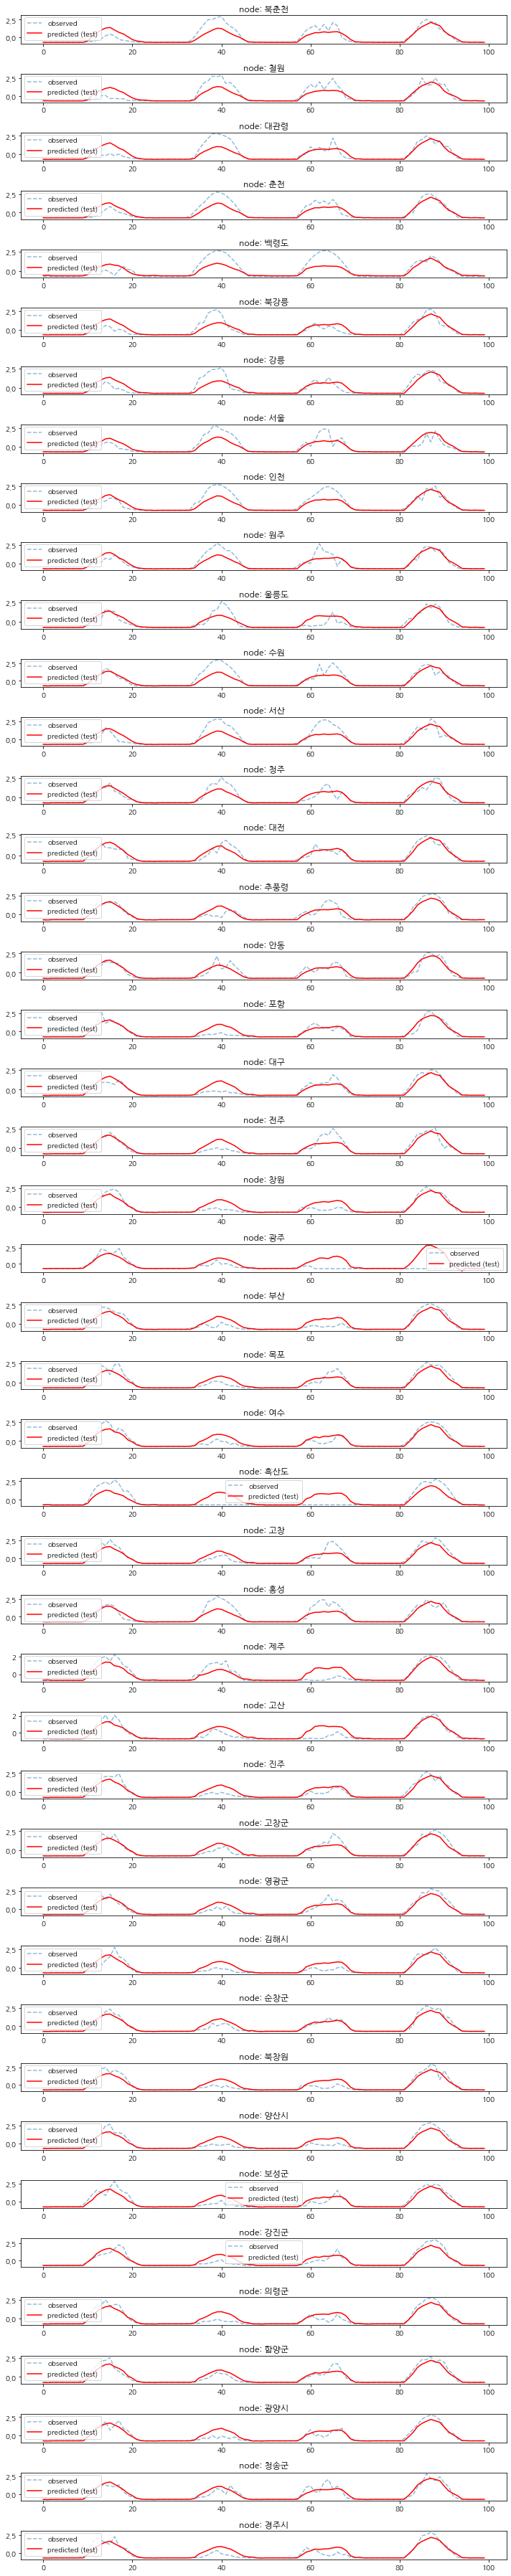

In [40]:
fig,ax = plt.subplots(44,1,figsize=(10,50))
lag= 0
T = 100 
for k in range(44):
    ax[k].plot(np.array(test_dataset.targets)[lag:(lag+T),k],'--',alpha=0.5,label='observed')
    ax[k].set_title('node: {}'.format(V[k]))
    ax[k].plot(yhat_test[:T,k],label='predicted (test)', color='red')
#    ax[k].plot(range(yhat_train.shape[0],yhat_train.shape[0]+yhat_test.shape[0]),yhat_test[:,k],label='predicted (test)')
    ax[k].legend()
fig.tight_layout()

# plt.savefig('stgcn-ver2-lag4-vis.png')